In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install torch torchvision opencv-python albumentations matplotlib scikit-learn tqdm pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import pandas as pd

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
class RiverDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # List all files
        image_files = sorted(os.listdir(img_dir))
        mask_files = sorted(os.listdir(mask_dir))
        
        # Get all valid image files
        self.images = []
        self.masks = []
        
        for img_name in image_files:
            if img_name.endswith('.jpg'):
                mask_name = img_name.rsplit('.', 1)[0] + '.png'
                mask_path = os.path.join(mask_dir, mask_name)
                
                if os.path.isfile(mask_path):
                    self.images.append(img_name)
                    self.masks.append(mask_name)
        
        print(f"Found {len(self.images)} valid image-mask pairs")
        if len(self.images) == 0:
            raise ValueError(f"No valid image-mask pairs found!")

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = self.masks[idx]
        
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert mask to float and normalize
        mask = mask.clone().detach().float().unsqueeze(0) / 255.0
        return image, mask

In [5]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use MobileNetV3 with weights parameter instead of pretrained
        self.backbone = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
        
        # Remove classifier and get features only
        self.backbone = self.backbone.features
        
        # Modified decoder to match feature dimensions
        self.decoder = nn.Sequential(
            # Starting from 960 channels at 7x7
            nn.ConvTranspose2d(960, 512, kernel_size=2, stride=2),  # 14x14
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 28x28
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 56x56
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # 112x112
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),    # 224x224
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 1, kernel_size=1),  # 224x224
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Get features from backbone
        features = self.backbone(x)
        # Decode to get segmentation mask
        output = self.decoder(features)
        return output

In [6]:
# Define transforms
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [7]:
# Set up paths and create datasets
base_dir = '/kaggle/input/river-water-segmentation-dataset/riwa_v2'
train_img_dir = os.path.join(base_dir, 'images')
train_mask_dir = os.path.join(base_dir, 'masks')
val_img_dir = os.path.join(base_dir, 'validation', 'images')
val_mask_dir = os.path.join(base_dir, 'validation', 'masks')

In [8]:
# Create datasets
train_dataset = RiverDataset(train_img_dir, train_mask_dir, transform=train_transform)
val_dataset = RiverDataset(val_img_dir, val_mask_dir, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Found 1027 valid image-mask pairs
Found 153 valid image-mask pairs
Training samples: 1027
Validation samples: 153


In [9]:
# Create and initialize model
model = SegmentationModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Test forward pass
test_input = torch.randn(1, 3, 224, 224).to(device)
test_output = model(test_input)
print(f"Test output shape: {test_output.shape}")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 126MB/s] 


Test output shape: torch.Size([1, 1, 224, 224])


In [21]:
# Training loop
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10: 100%|██████████| 65/65 [00:12<00:00,  5.33it/s]


Epoch 1: Train Loss = 0.0408, Val Loss = 0.2154


Epoch 2/10: 100%|██████████| 65/65 [00:12<00:00,  5.35it/s]


Epoch 2: Train Loss = 0.0433, Val Loss = 0.2150


Epoch 3/10: 100%|██████████| 65/65 [00:11<00:00,  5.57it/s]


Epoch 3: Train Loss = 0.0438, Val Loss = 0.1995


Epoch 4/10: 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]


Epoch 4: Train Loss = 0.0435, Val Loss = 0.1921


Epoch 5/10: 100%|██████████| 65/65 [00:11<00:00,  5.54it/s]


Epoch 5: Train Loss = 0.0393, Val Loss = 0.1976


Epoch 6/10: 100%|██████████| 65/65 [00:12<00:00,  5.41it/s]


Epoch 6: Train Loss = 0.0394, Val Loss = 0.1949


Epoch 7/10: 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]


Epoch 7: Train Loss = 0.0472, Val Loss = 0.1937


Epoch 8/10: 100%|██████████| 65/65 [00:11<00:00,  5.63it/s]


Epoch 8: Train Loss = 0.0438, Val Loss = 0.2075


Epoch 9/10: 100%|██████████| 65/65 [00:11<00:00,  5.51it/s]


Epoch 9: Train Loss = 0.0449, Val Loss = 0.2099


Epoch 10/10: 100%|██████████| 65/65 [00:11<00:00,  5.57it/s]


Epoch 10: Train Loss = 0.0436, Val Loss = 0.2564


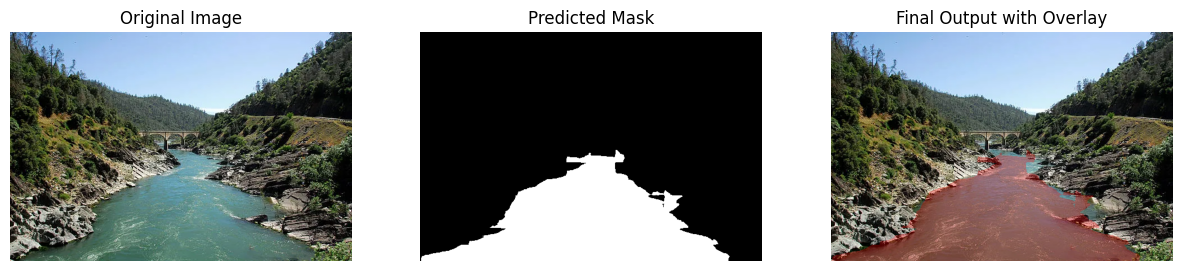

In [22]:
import cv2
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

def process_image(model, image_path="/kaggle/input/test-image-river/american-river.webp"):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"❌ Could not open image file: {image_path}")

    # Convert BGR to RGB for correct visualization
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define transformation (Resize & Normalize)
    transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # Apply transformation
    transformed = transform(image=rgb_image)
    input_tensor = transformed['image'].unsqueeze(0).to(device)

    # Run model inference
    model.eval()
    with torch.no_grad():
        pred_mask = model(input_tensor)

    # Process the predicted mask
    pred_mask = pred_mask.squeeze().cpu().numpy()
    pred_mask = cv2.resize(pred_mask, (image.shape[1], image.shape[0]))  # Resize back to original
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255  # Threshold & scale

    # Create overlay
    overlay = image.copy()
    overlay[pred_mask > 0] = [0, 0, 255]  # Apply red overlay for segmented region
    output = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)

    # Display results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(rgb_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(pred_mask, cmap="gray")
    ax[1].set_title("Predicted Mask")
    ax[1].axis("off")

    ax[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Final Output with Overlay")
    ax[2].axis("off")

    plt.show()

# Call the function to process and display your image
process_image(model, "/kaggle/input/test-image-river/american-river.webp")


In [23]:

import cv2
import numpy as np
import torch
from torchvision import transforms
import os

# ✅ Ensure model is loaded correctly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ✅ Input and output paths
input_video_path = '/kaggle/input/test-vdo-2/test_vdo_2.mp4'
output_video_path = '/kaggle/working/output_video_erosion.mp4'

# ✅ Open video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise ValueError(f"❌ Could not open video file: {input_video_path}")

# ✅ Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30  # Default FPS
frame_width = 512
frame_height = 512
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Try 'XVID' if issues arise
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# ✅ PyTorch transforms (added ToTensor)
torch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ✅ Parameters for erosion and filtering
min_area = 500  # Minimum area to keep regions
kernel_size = 5  # Erosion kernel size

# ✅ Function to apply region filtering based on area
def filter_regions_by_area(binary_mask, min_area):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_mask = np.zeros_like(binary_mask)
    for contour in contours:
        if cv2.contourArea(contour) > min_area:
            cv2.drawContours(filtered_mask, [contour], -1, 255, thickness=cv2.FILLED)
    return filtered_mask

# ✅ Process video frames
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("✅ End of video or error reading frame.")
        break

    # ✅ Resize frame
    resized_frame = cv2.resize(frame, (frame_width, frame_height))

    # ✅ Convert frame to RGB and tensor
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    frame_tensor = torch_transform(rgb_frame).unsqueeze(0).to(device)

    # ✅ Model prediction
    with torch.no_grad():
        mask = model(frame_tensor)[0].squeeze(0).cpu().numpy()  # (512, 512)

    # ✅ Threshold and resize mask
    binary_mask = (mask > 0.8).astype(np.uint8) * 255  # Binary segmentation mask
    binary_mask_resized = cv2.resize(binary_mask, (frame_width, frame_height))

    # ✅ Erosion for noise removal
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    eroded_mask = cv2.erode(binary_mask_resized, kernel, iterations=1)

    # ✅ Region filtering
    filtered_mask = filter_regions_by_area(eroded_mask, min_area)

    # ✅ Convert mask to 3-channel image
    filtered_mask_colored = np.zeros_like(resized_frame)
    filtered_mask_colored[:, :, 2] = filtered_mask  # Apply red channel for segmentation

    # ✅ Overlay mask on frame
    overlayed_frame = cv2.addWeighted(resized_frame, 1, filtered_mask_colored, 0.5, 0)

    # ✅ Write frame
    out.write(overlayed_frame)

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"✅ Processed {frame_count} frames.")

# ✅ Release resources
cap.release()
out.release()

# ✅ Verify output file existence
if os.path.exists(output_video_path):
    print(f"🎥 Processed video saved at: {output_video_path}")
else:
    print(f"❌ Video not saved! Check file path: {output_video_path}")


✅ Processed 100 frames.
✅ Processed 200 frames.
✅ Processed 300 frames.
✅ Processed 400 frames.
✅ Processed 500 frames.
✅ End of video or error reading frame.
🎥 Processed video saved at: /kaggle/working/output_video_erosion.mp4
